In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import os
import shutil
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading the datasets

In [3]:
df_train_clean = pd.read_csv('/content/drive/MyDrive/Satellite_Property_Project/train_processed.csv')
df_test_clean = pd.read_csv('/content/drive/MyDrive/Satellite_Property_Project/test_processed.csv')

I am loading the zip folder which contains the satellite images

In [4]:
import os
import shutil
import time

drive_zip_path = '/content/drive/MyDrive/Satellite_Property_Project/data/images_train.zip'

local_zip_path = '/content/images_train.zip'

local_extract_path = '/content/fast_images'

start_time = time.time()

if not os.path.exists(local_extract_path):
    print(f"Copying zip from Drive to Local Disk...")
    shutil.copy(drive_zip_path, local_zip_path)

    print(f"Unzipping to {local_extract_path}...")
    shutil.unpack_archive(local_zip_path, local_extract_path)
    os.remove(local_zip_path)

    duration = time.time() - start_time
    print(f"Process took {duration:.1f} second")
    print(f"Images are ready at: {local_extract_path}")
else:
    print("Images are already loaded locally")

Copying zip from Drive to Local Disk...
Unzipping to /content/fast_images...
Process took 60.0 second
Images are ready at: /content/fast_images


Unzippping folder and storing it in colab local memory for speed enhancement

In [5]:
source_path = '/content/drive/MyDrive/Satellite_Property_Project/data/images_train'
destination_path = '/content/fast_images'

print(f"Updating DataFrame paths from:\n {source_path} \n--> {destination_path}...")

df_train_clean['img_path'] = df_train_clean['img_path'].str.replace(source_path, destination_path)
df_test_clean['img_path'] = df_test_clean['img_path'].str.replace(source_path, destination_path)

print("\nSuccess! Here is a sample path:")
print(df_train_clean['img_path'].iloc[0])

Updating DataFrame paths from:
 /content/drive/MyDrive/Satellite_Property_Project/data/images_train 
--> /content/fast_images...

Success! Here is a sample path:
/content/fast_images/9117000170.jpg


Defining features that are to be scaled and overall features which are to be sent for training in the tabular pipeline

In [6]:
features_to_scale = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','sqft_basement',
    'lat', 'long','sqft_living15', 'sqft_lot15', 'house_age','grade', 'condition', 'view'
]

cols_to_use = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','sqft_basement','waterfront',
               'lat', 'long','sqft_living15', 'sqft_lot15', 'house_age','grade', 'condition', 'view','is_renovated']

Scaling

In [7]:
train_df, val_df = train_test_split(df_train_clean, test_size=0.2, random_state=42)

scaler = StandardScaler()
scaler.fit(train_df[features_to_scale])

train_df[features_to_scale] = scaler.transform(train_df[features_to_scale])
val_df[features_to_scale] = scaler.transform(val_df[features_to_scale])
df_test_clean[features_to_scale] = scaler.transform(df_test_clean[features_to_scale])

print(f"Train Size: {len(train_df)}")
print(f"Val Size: {len(val_df)}")

Train Size: 12956
Val Size: 3240


Defining Custom PyTorch Dataset for Multimodal Learning

In [8]:
class HousePriceDataset(Dataset):
    def __init__(self, dataframe, tabular_cols, transform=None, is_test=False):
        self.df = dataframe
        self.tabular_cols = tabular_cols
        self.transform = transform
        self.is_test = is_test

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        img_path = row['img_path']
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), color='black')

        if self.transform:
            image = self.transform(image)

        tabular = torch.tensor(row[self.tabular_cols].values.astype(np.float32), dtype=torch.float32)

        if not self.is_test:
            label = torch.tensor(row['log_price'], dtype=torch.float32)
            return image, tabular, label
        else:
            return image, tabular

Defining image transformation for compatibility with Resnet-50 model and creating loaders

In [9]:
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = HousePriceDataset(train_df, cols_to_use, transform=img_transforms)
val_dataset = HousePriceDataset(val_df, cols_to_use, transform=img_transforms)
test_dataset = HousePriceDataset(df_test_clean, cols_to_use, transform=img_transforms, is_test=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Defining path for storing the model weights after training

In [10]:
SAVE_PATH = '/content/drive/MyDrive/Satellite_Property_Project/refined_model/best_multimodal_model.pth'

Defining the multimodal architecture

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class MultimodalPricePredictor(nn.Module):
    def __init__(self, num_tab_features):
        super(MultimodalPricePredictor, self).__init__()

        self.resnet = models.resnet50(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.resnet.fc = nn.Identity()

        self.img_projector = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64)
        )

        self.tab_branch = nn.Sequential(
            nn.Linear(num_tab_features, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.fusion = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def train(self, mode=True):
        super().train(mode)
        self.resnet.eval()

    def forward(self, img, tab):
        img_feat = self.resnet(img)
        img_feat = self.img_projector(img_feat)
        tab_feat = self.tab_branch(tab)
        combined = torch.cat((img_feat, tab_feat), dim=1)
        out = self.fusion(combined)
        return out.squeeze()

Conducting training

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

model = MultimodalPricePredictor(num_tab_features=len(cols_to_use)).to(device)

criterion = nn.MSELoss()

optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3,
    weight_decay=1e-5
)

def train_model(num_epochs=30, patience=5):
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, tabular, labels in train_loader:
            images = images.to(device, non_blocking=True)
            tabular = tabular.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            optimizer.zero_grad()
            outputs = model(images, tabular)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, tabular, labels in val_loader:
                images = images.to(device)
                tabular = tabular.to(device)
                labels = labels.to(device)
                outputs = model(images, tabular)

                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), SAVE_PATH)
            print("Saved new best model")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered")
                break

    print("Training complete.")

train_model(num_epochs=50, patience=7)

Training on: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/50] Train Loss: 15.2621 | Val Loss: 1.1214
Saved new best model
Epoch [2/50] Train Loss: 1.6074 | Val Loss: 0.4219
Saved new best model
Epoch [3/50] Train Loss: 0.7466 | Val Loss: 0.1851
Saved new best model
Epoch [4/50] Train Loss: 0.3212 | Val Loss: 0.0969
Saved new best model
Epoch [5/50] Train Loss: 0.1703 | Val Loss: 0.0690
Saved new best model
Epoch [6/50] Train Loss: 0.1317 | Val Loss: 0.0901
Epoch [7/50] Train Loss: 0.1135 | Val Loss: 0.0610
Saved new best model
Epoch [8/50] Train Loss: 0.1345 | Val Loss: 0.0697
Epoch [9/50] Train Loss: 0.0970 | Val Loss: 0.0565
Saved new best model
Epoch [10/50] Train Loss: 0.0900 | Val Loss: 0.0567
Epoch [11/50] Train Loss: 0.0856 | Val Loss: 0.0521
Saved new best model
Epoch [12/50] Train Loss: 0.0794 | Val Loss: 0.0583
Epoch [13/50] Train Loss: 0.0837 | Val Loss: 0.0546
Epoch [14/50] Train Loss: 0.0791 | Val Loss: 0.0509
Saved new best model
Epoch [15/50] Train Loss: 0.0750 | Val Loss: 0.0531
Epoch [16/50] Train Loss: 0.0935 | Val 

Generating R2 and RMSE scores

In [15]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

model.load_state_dict(torch.load(SAVE_PATH))
model.eval()

val_preds, val_targets = [], []

with torch.no_grad():
    for images, tabular, labels in val_loader:
        images = images.to(device)
        tabular = tabular.to(device)
        labels = labels.to(device)

        out = model(images,tabular)
        val_preds.extend(out.cpu().numpy().flatten())
        val_targets.extend(labels.cpu().numpy().flatten())

y_true = np.expm1(val_targets)
y_pred = np.expm1(val_preds)

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print("----------------------------")
print("MULTIMODAL RESULTS:")
print(f"R2 Score: {r2:.4f}")
print(f"RMSE:     ${rmse:,.2f}")
print("----------------------------")


----------------------------
MULTIMODAL RESULTS:
R2 Score: 0.8359
RMSE:     $143,104.15
----------------------------


In [14]:
device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Evaluating on: {device}")

Evaluating on: cuda


Generating predictions on test dataset and saving the submission file .

In [15]:
test_dataset_final = HousePriceDataset(
    df_test_clean,
    cols_to_use,
    transform=img_transforms,
    is_test=True
)

test_loader_final = DataLoader(
    test_dataset_final,
    batch_size=32,
    shuffle=False,
    num_workers=2
)

model = MultimodalPricePredictor(num_tab_features=len(cols_to_use))
model = model.to(device)

model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.eval()

print("Model loaded. Starting predictions...")

predictions = []

with torch.no_grad():
    for batch in tqdm(test_loader_final, desc="Generating Predictions"):
        images, tabular = batch
        images = images.to(device)
        tabular = tabular.to(device)
        outputs = model(images, tabular)
        preds_dollar = np.expm1(outputs.cpu().numpy().flatten())
        predictions.extend(preds_dollar)
submission_df = pd.DataFrame({
    'id': df_test_clean['id'],
    'predicted_price': predictions
})

output_path = '/content/drive/MyDrive/Satellite_Property_Project/23119050_final.csv'
submission_df.to_csv(output_path, index=False)

print(f"Submission saved to: {output_path}")
print(submission_df.head())

Model loaded. Starting predictions...


Generating Predictions: 100%|██████████| 169/169 [00:40<00:00,  4.19it/s]

Submission saved to: /content/drive/MyDrive/Satellite_Property_Project/23119050_final.csv
           id  predicted_price
0  2591820310     3.574156e+05
1  7974200820     8.804424e+05
2  7701450110     1.230889e+06
3  9522300010     1.907076e+06
4  9510861140     6.456471e+05


# **GRAD CAM Explainabilty code with results**


In [17]:
model = MultimodalPricePredictor(num_tab_features=len(cols_to_use))

try:
    model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
    print(f"✅ Successfully loaded model from: {SAVE_PATH}")
except FileNotFoundError:
    print("Could not find the model file!")

Evaluating on: cpu


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ Successfully loaded model from: /content/drive/MyDrive/Satellite_Property_Project/refined_model/best_multimodal_model.pth


Visualizing what influenced the price...


/tmp/ipython-input-1679588231.py:32: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  output.backward(retain_graph=True)
/tmp/ipython-input-1679588231.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(), 0)
/tmp/ipython-input-1679588231.py:68: RuntimeWarning: invalid value encountered in cast
  heatmap_resized = np.uint8(255 * heatmap_resized)


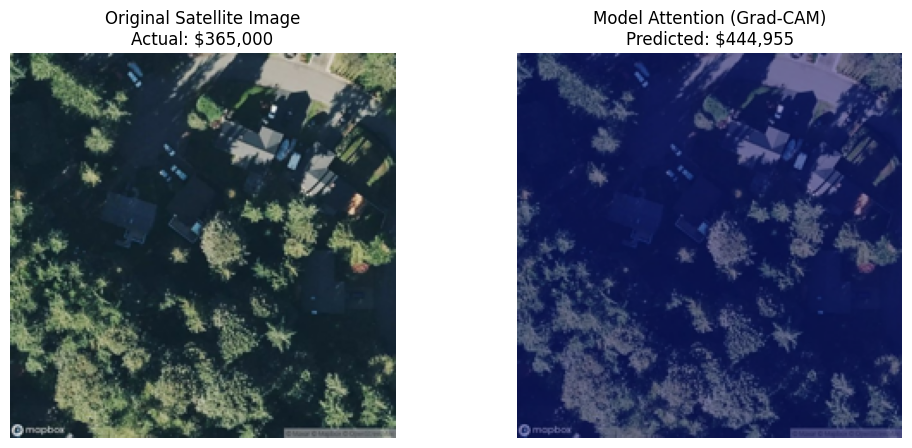

/tmp/ipython-input-1679588231.py:32: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  output.backward(retain_graph=True)
/tmp/ipython-input-1679588231.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(), 0)


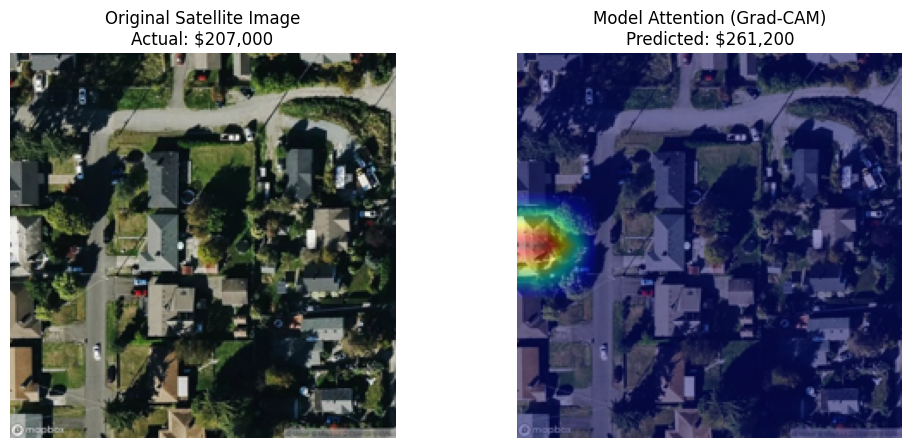

/tmp/ipython-input-1679588231.py:32: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  output.backward(retain_graph=True)
/tmp/ipython-input-1679588231.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(), 0)


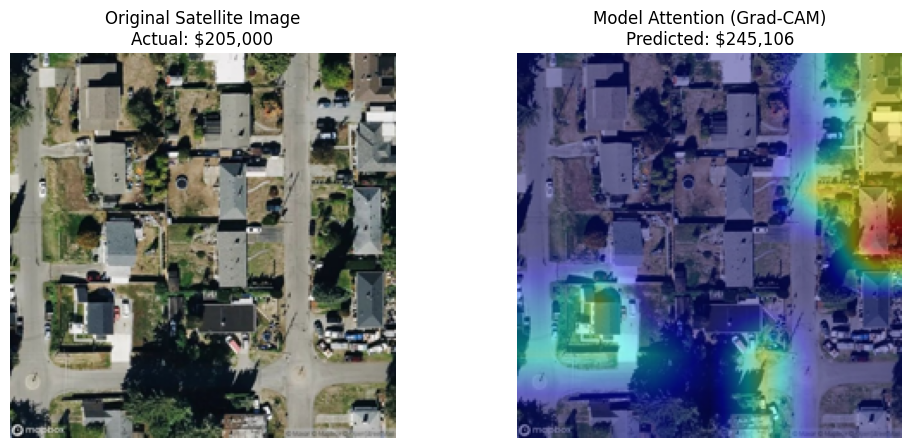

/tmp/ipython-input-1679588231.py:32: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  output.backward(retain_graph=True)
/tmp/ipython-input-1679588231.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(), 0)


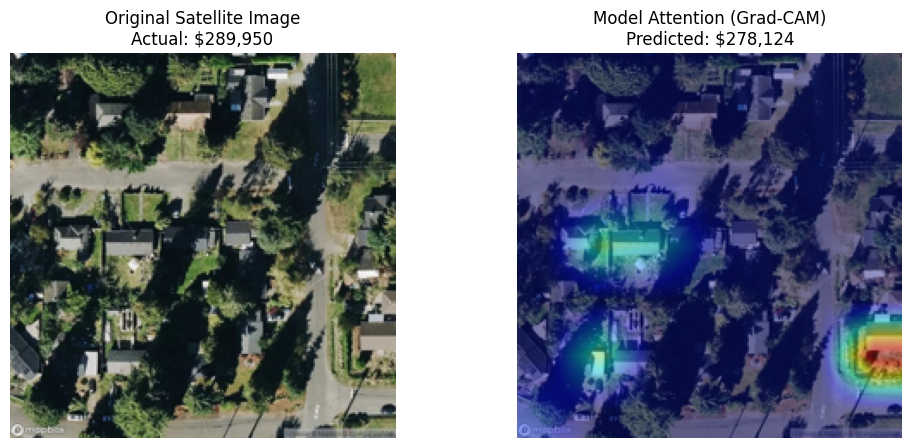

/tmp/ipython-input-1679588231.py:32: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  output.backward(retain_graph=True)
/tmp/ipython-input-1679588231.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(), 0)


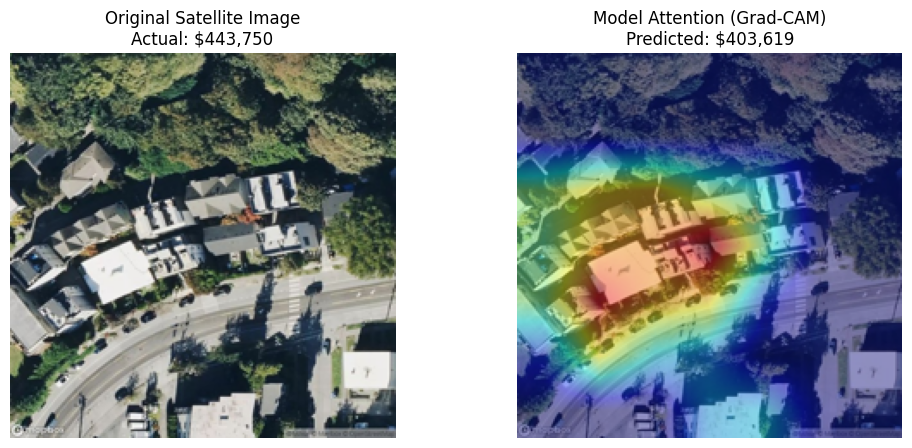

/tmp/ipython-input-1679588231.py:32: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  output.backward(retain_graph=True)
/tmp/ipython-input-1679588231.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  heatmap = np.maximum(heatmap.cpu(), 0)


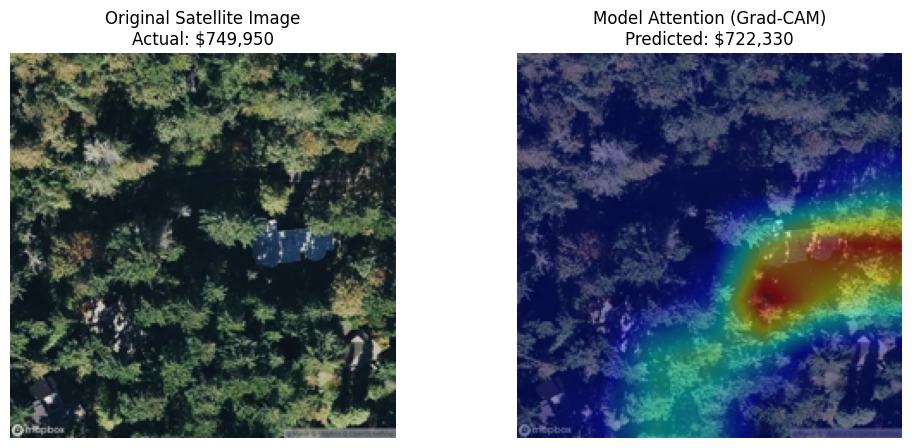

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.feature_maps = None

        for param in self.target_layer.parameters():
            param.requires_grad = True

        self.target_layer.register_forward_hook(self.save_feature_maps)
        self.target_layer.register_full_backward_hook(self.save_gradients)

    def save_feature_maps(self, module, input, output):
        self.feature_maps = output

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, img_input, tab_input):
        self.model.eval()

        output = self.model(img_input, tab_input)

        self.model.zero_grad()
        output.backward(retain_graph=True)

        if self.gradients is None:
            raise ValueError("Gradients are None! The hook did not fire. Ensure target_layer.requires_grad is True.")

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        activations = self.feature_maps.detach()
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze()
        heatmap = np.maximum(heatmap.cpu(), 0)
        heatmap /= torch.max(heatmap)

        return heatmap.numpy()

def show_explainability(index_in_val):
    try:
        img_tensor, tab_tensor, label_log = val_dataset[index_in_val]
    except NameError:
        print("ERROR: 'val_dataset' not found. Please re-run your Data Loading cell.")
        return

    img_input = img_tensor.unsqueeze(0).to(device)
    tab_input = tab_tensor.unsqueeze(0).to(device)

    target_layer = model.resnet.layer4[-1]

    grad_cam = GradCAM(model, target_layer)
    heatmap = grad_cam(img_input, tab_input)

    img_path = val_df.iloc[index_in_val]['img_path']
    original_img = Image.open(img_path).resize((224, 224))

    heatmap_resized = cv2.resize(heatmap, (224, 224))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    img_np = np.array(original_img)
    img_bgr = cv2.cvtColor(img_np, cv2.COLOR_RGB2BGR)
    superimposed = cv2.addWeighted(img_bgr, 0.6, heatmap_colored, 0.4, 0)
    superimposed = cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB)

    with torch.no_grad():
        pred_log = model(img_input, tab_input).item()

    if isinstance(label_log, torch.Tensor):
        label_val = label_log.item()
    else:
        label_val = label_log

    real_price = np.expm1(label_val)
    pred_price = np.expm1(pred_log)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title(f"Original Satellite Image\nActual: ${real_price:,.0f}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title(f"Model Attention (Grad-CAM)\nPredicted: ${pred_price:,.0f}")
    plt.axis('off')

    plt.show()

print("Visualizing what influenced the price...")
show_explainability(index_in_val=0)
show_explainability(index_in_val=902)
show_explainability(index_in_val=210)
show_explainability(index_in_val=1290)
show_explainability(index_in_val=1056)
show_explainability(index_in_val=310)